In [1]:
import json
import os
import re
import random
import numpy as np

from collections import Counter
from matplotlib import pyplot as plt 
from transformers import BertTokenizerFast, BertTokenizer

#from utils.data_util import split_text
import config

In [2]:
train_data = []
dev_data = []

data_in_dir = config.data_in_dir
with open(os.path.join(data_in_dir, 'train.json')) as tf:
    train_data = [json.loads(line) for line in tf.readlines()]

with open(os.path.join(data_in_dir, 'dev.json')) as df:
    dev_data = [json.loads(line) for line in df.readlines()]

with open(os.path.join(data_in_dir, 'event_schema.json')) as sf:
    schema = [json.loads(line) for line in sf.readlines()]

In [3]:
print(len(train_data))
print(len(dev_data))
print(len(schema))

7047
1174
13


In [4]:
special_event_type = []
None_event_list = []
for data in (train_data + dev_data):
    if "event_list" not in data:
        None_event_list.append(data)
        continue
    event_types = []
    for event in data["event_list"]:
        event_types.append(event["event_type"])
    event_types = dict(Counter(event_types))
    for etype, num in event_types.items():
        if num > 1:
            special_event_type.append(etype)
special_event_type =  dict(Counter(special_event_type))
print('one event_type have multi event:', special_event_type)
print()
print("Number: data have not event_list:", len(None_event_list))
all_num = 0

for event_type, num in special_event_type.items():
    all_num += num
print(all_num)
        
            


one event_type have multi event: {'企业收购': 130, '股东增持': 70, '高管变动': 279, '中标': 99, '股份回购': 237, '亏损': 229, '公司上市': 36, '质押': 305, '解除质押': 99, '股东减持': 185, '被约谈': 33, '企业融资': 61, '企业破产': 21}

Number: data have not event_list: 1048
1784


In [5]:
special_roles = []
for data in train_data + dev_data:
    special_role = []
    if 'event_list' in data:
        event_num = len(data["event_list"])
        event_list = data["event_list"]
        common_role = set()
        if event_num > 1:
            for i in range(event_num - 1):
                for j in range(i+1, event_num):
                    if event_list[i]["event_type"] == event_list[j]["event_type"]:
                        first_event_role = set([(event_list[i]["event_type"] + '_' + argument["role"], argument["argument"]) for argument in event_list[i]["arguments"]])
                        second_event_role = set([(event_list[i]["event_type"] + '_' + argument["role"], argument["argument"]) for argument in event_list[j]["arguments"]])
                        common_role.update(first_event_role & second_event_role)
                        special_role.extend([role[0] for role in list(first_event_role - common_role)])
                        special_role.extend([role[0] for role in list(second_event_role - common_role)])
    special_role = list(set(special_role))
    special_roles.extend(special_role)
special_roles = dict(Counter(special_roles))
                        


In [6]:
print(special_roles)

{'企业收购_被收购方': 107, '企业收购_收购完成时间': 68, '企业收购_披露时间': 50, '股东增持_交易完成时间': 41, '股东增持_每股交易价格': 20, '股东增持_交易股票/股份数量': 53, '高管变动_高管职位': 224, '高管变动_变动后职位': 244, '高管变动_高管姓名': 274, '高管变动_变动类型': 227, '中标_招标方': 39, '中标_中标金额': 64, '中标_中标标的': 73, '股份回购_披露时间': 43, '股份回购_交易金额': 227, '股份回购_占公司总股本比例': 213, '股份回购_每股交易价格': 224, '股份回购_回购完成时间': 229, '股份回购_回购股份数量': 230, '企业收购_交易金额': 84, '企业收购_收购标的': 70, '高管变动_事件时间': 101, '亏损_净亏损': 228, '亏损_财报周期': 221, '亏损_披露时间': 13, '公司上市_市值': 3, '公司上市_上市公司': 29, '公司上市_事件时间': 20, '亏损_亏损变化': 116, '亏损_公司名称': 11, '高管变动_变动后公司名称': 55, '高管变动_任职公司': 74, '质押_质押物占持股比': 258, '质押_质押方': 168, '质押_事件时间': 188, '质押_质押物占总股比': 233, '质押_质押股票/股份数量': 274, '质押_质权方': 94, '解除质押_质押股票/股份数量': 83, '解除质押_质押方': 43, '解除质押_事件时间': 68, '质押_质押物所属公司': 19, '股东增持_交易金额': 34, '股东增持_增持方': 23, '股东增持_股票简称': 26, '股东增持_增持部分占总股本比例': 24, '解除质押_质权方': 32, '解除质押_质押物占持股比': 62, '股东减持_交易股票/股份数量': 147, '股东减持_减持方': 127, '中标_中标公司': 57, '中标_披露日期': 15, '质押_质押物': 66, '解除质押_披露时间': 7, '解除质押_质押物': 14, '高管变动_披露日期': 37, '解除质押_质押物占总股比': 57

In [7]:
# 每个篇章最多多少个事件
num = []
for data in train_data+dev_data:
    if "event_list" in data:
        if len(data["event_list"]) == 16:
            print(data)
            print(len(data["text"]))
        num.append(len(data["event_list"]))
max_num = max(num)
print("一个文章中最多的事件数：", max_num)

{'text': '如何在结构性行情中开展投资布局？新浪财经《基金直播间》，邀请基金经理在线路演解读市场。\n原标题：置信电气(7.200,0.01,0.14%)董事长辞职，董监高彻底“大换血”    来源：华夏能源网\n华夏能源网（www.hxny.com）获悉，4月16日晚间，上海置信电气股份有限公司（下称“置信电气”，600517.SH）发布公告称，因工作原因，宋云翔申请辞去第七届董事会董事长、董事会专门委员会的相关职务及总经理职务。\n宋云翔的辞职报告将在公司股东大会选举产生新任董事后生效。此外，董事会收到董事杨骥珉、副总经理蔡炜、副总经理邢峻、副总经理李力、副总经理左振鲁、总会计师何克飞、副总经理徐洪海的辞职报告，上述辞职报告自送达公司董事会之日起生效。\n此前在3月30日晚间，置信电气发布了一系列人事变动公告。该公告显示，杨骥珉将辞去副董事长职务，但保留董事和董事会专门委员会的相关职务；蔡炜、邢峻、刘广林、赵仰东、李力等5名非独立董事则申请辞去第七届董事会董事和董事会专门委员会的相关职务；阙连元申请辞去第七届监事会监事长、监事职务，陈建玉申请辞去第七届监事会监事职务。\n其中，刘广林是国网电力科学研究院有限公司企业管理协会副会长、秘书处秘书长，而国网电科院(6.860,-0.03,-0.44%)正是此前置信电气的第一大股东。', 'event_list': [{'trigger': '辞去', 'event_type': '高管变动', 'arguments': [{'role': '披露日期', 'argument': '4月16日晚间'}, {'role': '任职公司', 'argument': '上海置信电气股份有限公司'}, {'role': '高管姓名', 'argument': '宋云翔'}, {'role': '变动类型', 'argument': '辞去'}, {'role': '高管职位', 'argument': '第七届董事会董事长'}, {'role': '高管职位', 'argument': '董事会专门委员会的相关职务'}, {'role': '高管职位', 'argument': '总经理'}]}, {'trigger': '辞职', 'event_type': '高管变动', 'arguments': [{'role':

In [8]:
# 对于特殊角色  环节， 是否事件类型公司上市出现时，其一定会出现
for data in train_data+dev_data:
    if "event_list" in data:
        for event in data["event_list"]:
            if event["event_type"] == "公司上市":
                roles = []
                for argument in event["arguments"]:
                    roles.append(argument["role"])
                if "环节" not in roles:
                    raise ValueError("存在公司上市事件类型， 没有环节这一角色！")
# 最终判断只要是公司上市事件类型， 必存在环节， 故可以将具体环节和公司上市绑定

## 数据清洗

In [9]:
all_data = train_data + dev_data

In [10]:
# 特殊字符以及脏数据
# text中的特殊字符
text_data = [data['text'] for data in all_data]
special = set()
sp_char_ind = []
for id, text in enumerate(text_data):
    
    if re.findall(r'<br/>', text):
        sp_char_ind.append(id)

    special.update(set(re.findall(r'<a[^>]*>', text)))
    special.update(set(re.findall(r'<p[^>]*>', text)))
    special.update(set(re.findall(r'</a*>', text)))
    special.update(set(re.findall(r'</p*>', text)))
    special.update(set(re.findall(r'<br>', text)))
    special.update(set(re.findall(r'<br/>', text)))
    special.update(set(re.findall(r'<strong[^>]*>', text)))
    special.update(set(re.findall(r'</strong>', text)))
    special.update(set(re.findall(r'<script[^>]*>', text)))
    special.update(set(re.findall(r'</script>', text)))
    special.update(set(re.findall(r'/div>', text)))
    # 网址
    # special.update(set(re.findall(r'(?:https?|ftp|file)://[-A-Za-z0-9+&@#/%?=~_|!:,.;]+[-A-Za-z0-9+&@#/%=~_|]', text)))

    special.update(set(re.findall(r'<img[^>]*>', text)))
    special.update(set(re.findall(r'&lt;/img=&quot;&quot;]', text)))
    special.update(set(re.findall(r'&lt;/img=""]', text)))
    special.update(set(re.findall(r'&lt;', text)))
    special.update(set(re.findall(r'&gt;', text)))
    special.update(set(re.findall(r'&nbsp;', text)))
    
    #不可见字符
    special.update(set(re.findall(r'\s', text)))
    
    

print(special)

{'\u2002', '\t', '\n', '&nbsp;', '\u2003', ' ', '\u3000'}


In [11]:
# 数据集文本中包含较多的 网址， 是否需要清洗？？
all_data[4427]


{'text': '原标题：蔚来汽车盘前跌幅扩大至13% 蔚来汽车二季度亏逾32亿\n蔚来汽车盘前股价由涨转跌，跌幅扩至13％，蔚来今日发布了第二季度财报，随后宣布取消原定于今日举行的财报电话会议。\n财报显示，蔚来汽车二季度实现营收15.08亿元，高于市场预期的13.09亿元，去年同期为4600万元；第二季度归属于股东净亏损32.85亿元，高于市场预期的亏损29.44亿元，去年同期亏损61.1亿元。',
 'event_list': [{'trigger': '亏损',
   'event_type': '亏损',
   'arguments': [{'role': '公司名称', 'argument': '蔚来汽车'},
    {'role': '披露时间', 'argument': '今日'},
    {'role': '净亏损', 'argument': '32.85亿元'},
    {'role': '财报周期', 'argument': '第二季度'}]},
  {'trigger': '亏损',
   'event_type': '亏损',
   'arguments': [{'role': '公司名称', 'argument': '蔚来汽车'},
    {'role': '披露时间', 'argument': '今日'},
    {'role': '财报周期', 'argument': '去年同期'},
    {'role': '净亏损', 'argument': '61.1亿元'}]}],
 'id': '161a95aef91084df16e12ba60b207335',
 'title': '蔚来汽车盘前跌幅扩大至13% 蔚来汽车二季度亏逾32亿'}

## 句子长度分布

In [12]:
tokenizer = BertTokenizerFast.from_pretrained(config.bert_config["bert_path"], add_special_tokens = False, do_lower_case = False)
tokenize = tokenizer.tokenize

最大长度：3398
最小长度：11
平均长度：830.9567262464723


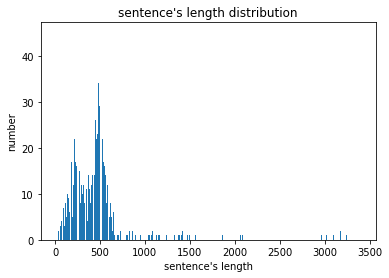

In [13]:
# 句子长度分布
text_lens = dict(Counter([len(tokenize(data['text'])) for data in all_data]))
x_len = np.array(list(text_lens.keys()))
y_num = np.array(list(text_lens.values()))

print('最大长度：' + str(x_len.max()))
print('最小长度：' + str(x_len.min()))
print('平均长度：' + str(np.mean(x_len)))
plt.title('sentence\'s length distribution')
plt.xlabel('sentence\'s length')
plt.ylabel('number')
plt.bar(x_len, y_num)
plt.show()

最大长度：127
最小长度：5
平均长度：41.12698412698413


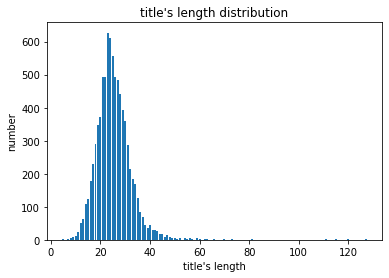

In [14]:
# 标题长度分布
text_lens = dict(Counter([len(tokenize(data['title'])) for data in all_data]))
x_len = np.array(list(text_lens.keys()))
y_num = np.array(list(text_lens.values()))

print('最大长度：' + str(x_len.max()))
print('最小长度：' + str(x_len.min()))
print('平均长度：' + str(np.mean(x_len)))
plt.title('title\'s length distribution')
plt.xlabel('title\'s length')
plt.ylabel('number')
plt.bar(x_len, y_num)
plt.show()

### 处理“环节”角色
#### 1. 将数据中涉及到公司上市的事件类型， 改为公司上市#环节argument
#### 2. 将schema中的事件类型做同等处理， 并在合并事件类型_role时， 把‘环节去掉’

In [15]:
for i, data in enumerate(all_data):
    if "event_list" in data:
        for event in data["event_list"]:
            if event["event_type"] == '公司上市':
                for argument in event["arguments"]:
                    if argument["role"] == "环节":
                        event_type = event["event_type"] + '#' + argument["argument"]
                        break
                event["event_type"] = event_type
                

In [16]:
tag = []
enum_items =  ["筹备上市", "暂停上市", "正式上市", "终止上市"]
for s in schema:
    if s["event_type"] == "公司上市":
        event_type = ["公司上市" + "#" + item for item in enum_items]
    else:
        event_type = [s["event_type"]]
    for role in s["role_list"]:
        for e_type in event_type:
            if role["role"] != "环节":
                tag.append(e_type + "_" + role["role"])

In [20]:
tag2id = {tag: id for id, tag in enumerate(tag)}

In [21]:
tag2id

{'解除质押_质押方': 0,
 '解除质押_披露时间': 1,
 '解除质押_质权方': 2,
 '解除质押_质押物': 3,
 '解除质押_质押股票/股份数量': 4,
 '解除质押_事件时间': 5,
 '解除质押_质押物所属公司': 6,
 '解除质押_质押物占总股比': 7,
 '解除质押_质押物占持股比': 8,
 '股份回购_回购方': 9,
 '股份回购_披露时间': 10,
 '股份回购_回购股份数量': 11,
 '股份回购_每股交易价格': 12,
 '股份回购_占公司总股本比例': 13,
 '股份回购_交易金额': 14,
 '股份回购_回购完成时间': 15,
 '股东减持_股票简称': 16,
 '股东减持_披露时间': 17,
 '股东减持_交易股票/股份数量': 18,
 '股东减持_每股交易价格': 19,
 '股东减持_交易金额': 20,
 '股东减持_交易完成时间': 21,
 '股东减持_减持方': 22,
 '股东减持_减持部分占所持比例': 23,
 '股东减持_减持部分占总股本比例': 24,
 '亏损_公司名称': 25,
 '亏损_披露时间': 26,
 '亏损_财报周期': 27,
 '亏损_净亏损': 28,
 '亏损_亏损变化': 29,
 '中标_中标公司': 30,
 '中标_中标标的': 31,
 '中标_中标金额': 32,
 '中标_招标方': 33,
 '中标_中标日期': 34,
 '中标_披露日期': 35,
 '高管变动_高管姓名': 36,
 '高管变动_任职公司': 37,
 '高管变动_高管职位': 38,
 '高管变动_事件时间': 39,
 '高管变动_变动类型': 40,
 '高管变动_披露日期': 41,
 '高管变动_变动后职位': 42,
 '高管变动_变动后公司名称': 43,
 '企业破产_破产公司': 44,
 '企业破产_披露时间': 45,
 '企业破产_债务规模': 46,
 '企业破产_破产时间': 47,
 '企业破产_债权人': 48,
 '股东增持_股票简称': 49,
 '股东增持_披露时间': 50,
 '股东增持_交易股票/股份数量': 51,
 '股东增持_每股交易价格': 52,
 '股东增持_交易金额': 53,
 '股东增持_交易完成时间

## 划分为7折

#### 一部分标注内容只在标题中存在，在text中不存在

In [22]:
print(len(all_data))

8221


In [23]:
def split_k_data(data, shuffle=True, k=10):
    '''将数据随机分为k等份
    '''
    split_data = []
    num_data = len(data)
    offset = int(num_data / k)
    if num_data == 0 or offset < 2:
        raise ValueError('数据不存在或k值太大')
    if shuffle:
        random.shuffle(data)
    return [data[i*offset : ] if i == k-1 else data[i*offset : (i+1)*offset] for i in range(k)]

In [24]:
data_10_fold = split_k_data(all_data, shuffle=True, k=7)

In [25]:
print(len(data_10_fold[0]), len(data_10_fold[-1]))

1174 1177


In [26]:
for ind, data in enumerate(data_10_fold):
    data_10_fold_path = os.path.join(config.data_out_dir, config.common["exp_name"])
    if not os.path.exists(data_10_fold_path):
        os.mkdir(data_10_fold_path)
    with open(os.path.join(data_10_fold_path, 'data_{}.json'.format(ind)), 'w', encoding = "utf-8") as f:
        json.dump(data, f, ensure_ascii = False)

In [27]:
tag_path = os.path.join(config.data_out_dir, config.common["exp_name"], 'tag2id.json')
with open(tag_path, 'w', encoding = "utf-8") as f:
        json.dump(tag2id, f, ensure_ascii = False)